In [430]:
import pandas as pd
import numpy as np
import math
from datetime import date

import yfinance as yf

from scipy.signal import argrelextrema
from scipy.stats import percentileofscore

import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import  to_rgba

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


In [431]:
# Loading the dataset
start_date = "2000-01-01"
end_date = date.today().strftime('%Y-%m-%d')
data = yf.download('^NSEI', start=start_date, end=end_date, progress=False) # uncomment when executing for NIFTY
# data = pd.read_csv('datasets/bitcoin_data.csv') # Comment out when executing for NIFTY

# Renaming the columns
data.columns = data.columns.get_level_values(0) # uncomment when executing for NIFTY
data.reset_index(inplace=True) # uncomment when executing for NIFTY
data = data[['Date', 'Open', 'High', 'Low', 'Close']].copy() # uncomment when executing for NIFTY
data.columns = ['date', 'open', 'high', 'low', 'close']

# Changing the Datetime Format
data['date'] = pd.to_datetime(data['date'])

# Ensuring Data Sanity
data.drop_duplicates(subset=['date'], inplace=True)
data.sort_values('date', inplace=True)

In [ ]:
# Detrended Price using 200 day Simple Moving Average
trend_window = 200
trend = data['close'].rolling(window=trend_window).mean()
data['trend'] = trend

# Percentage deviation of "close" from trend
data['detrended_price'] = ((data['close'] - data['trend']) / data['trend'])*100

# Using Hodrick Preston Filter to find trend highs/lows which are then used to find the swing highs/lows
cycle, trendX = sm.tsa.filters.hpfilter(data['close'], lamb=25)
data['smtrend'] = trendX
data['trend_high'] = data[(data.smtrend > data.smtrend.shift(1)) & (data.smtrend > data.smtrend.shift(-1))]['close']
data['trend_low'] = data[(data.smtrend < data.smtrend.shift(1)) & (data.smtrend < data.smtrend.shift(-1))]['close']

# Binary tagging the candles for For Swing High / Low
data['swing_high'] = data['trend_high'].notna().astype(int)
data['swing_low'] = data['trend_low'].notna().astype(int)

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [ ]:
# Dropping some columns that might not be useful in the future
data.drop(columns=['trend_high', 'trend_low'], inplace=True)

In [ ]:
# Filtering out the individual swing high/low points into independent dataframes
support_candidates = (
    data[data['swing_low'] == 1]
    .loc[:, ['date', 'low']]
    .rename(columns={'low': 'price'})
    .copy()
)
support_candidates['type'] = 'support'
support_candidates.reset_index(drop=True, inplace=True)

resistance_candidates = (
    data[data['swing_high'] == 1]
    .loc[:, ['date', 'high']]
    .rename(columns={'high': 'price'})
    .copy()
)
resistance_candidates['type'] = 'resistance'
resistance_candidates.reset_index(drop=True, inplace=True)

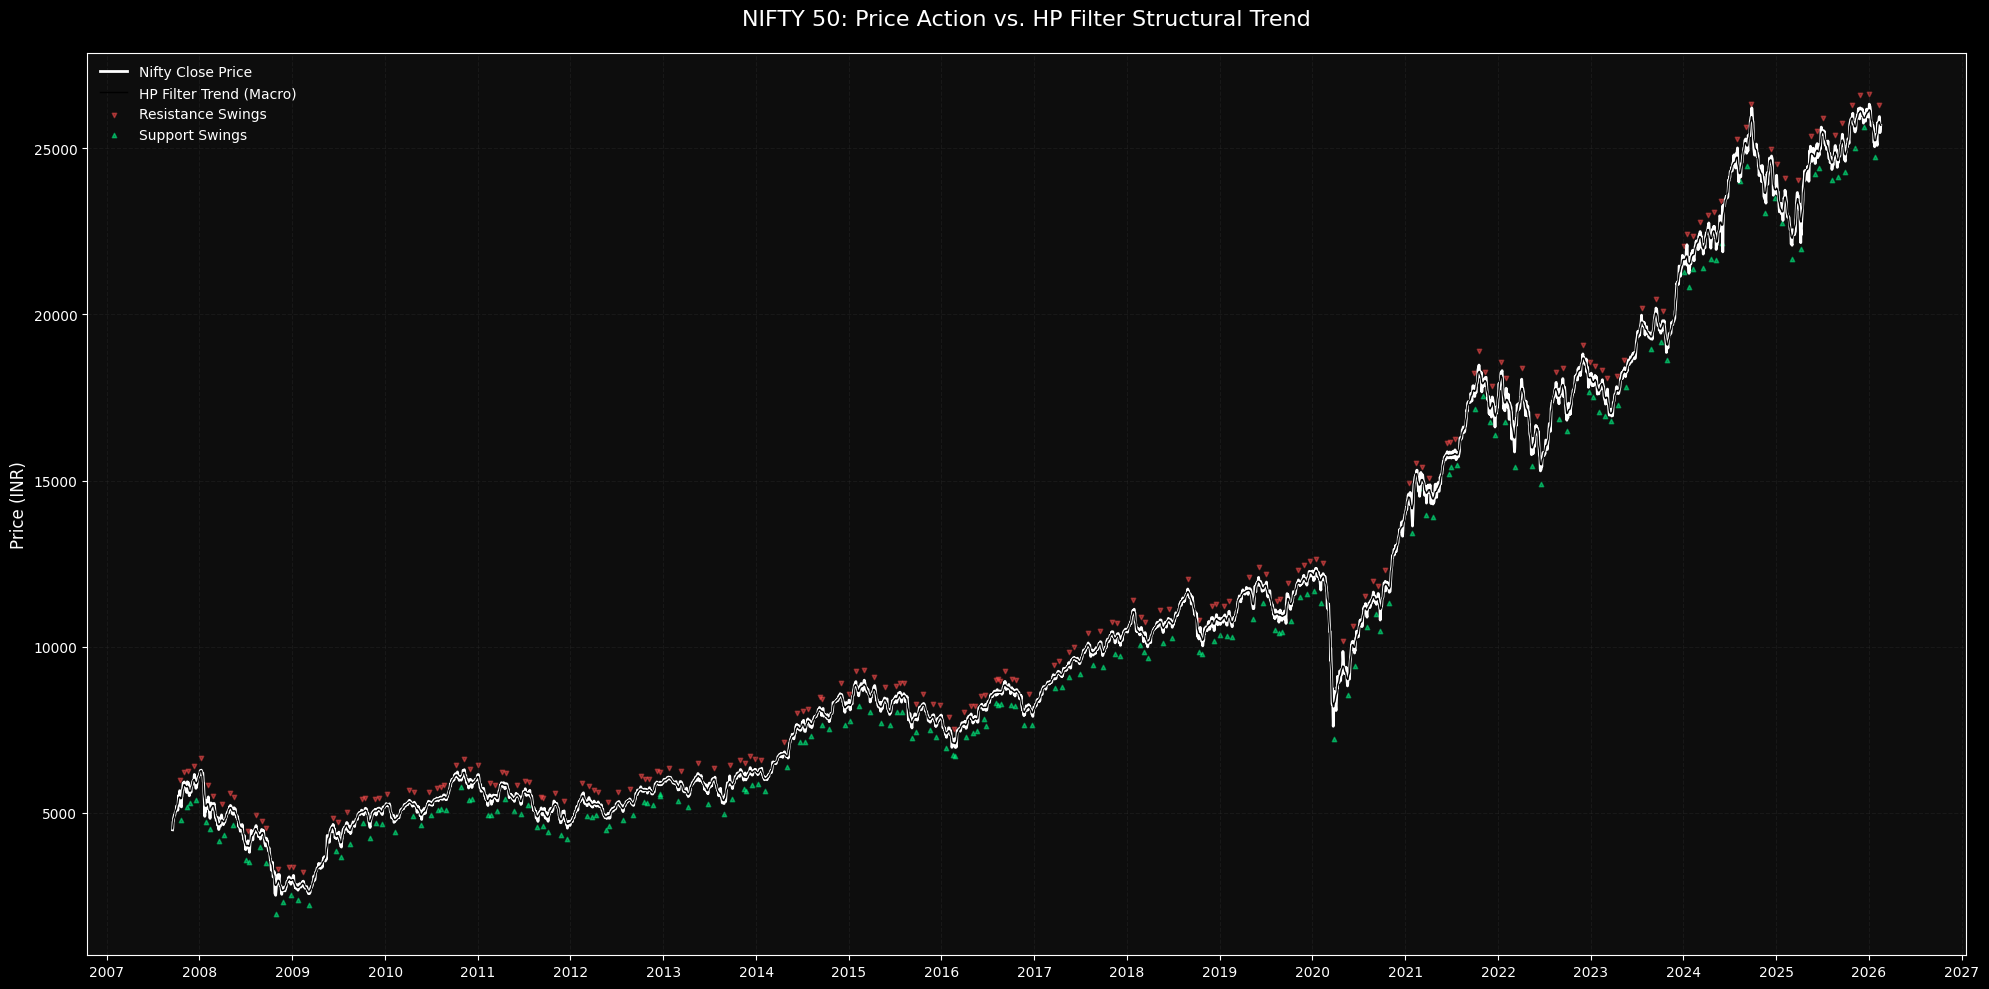

In [ ]:
# Set the dark style
plt.style.use('dark_background')

# Visualizing the Swing points on the graph
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('#0d0d0d')

ax.plot(data['date'], data['close'], color="#ffffff", linewidth=2, label='Nifty Close Price')

ax.plot(data['date'], data['smtrend'], color="#000000", linewidth=1, label='HP Filter Trend (Macro)')

ax.scatter(resistance_candidates['date'], resistance_candidates['price']+300, 
           color='#ff4d4d', s=10, marker='v', alpha=0.5, label='Resistance Swings')
ax.scatter(support_candidates['date'], support_candidates['price']-300, 
           color='#00ff88', s=10, marker='^', alpha=0.5, label='Support Swings')

ax.set_title("NIFTY 50: Price Action vs. HP Filter Structural Trend", color='white', fontsize=16, pad=20)
ax.set_ylabel("Price (INR)", color='white', fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.tick_params(colors='white', which='both', labelsize=10)

ax.grid(True, color='#333333', linestyle='--', alpha=0.3)
ax.legend(loc='upper left', frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Computing True Range
high_low = data['high'] - data['low']  # current high minus current low
high_close = (data['high'] - data['close'].shift(1)).abs() # absolute of current high minus prev day's close
low_close = (data['low'] - data['close'].shift(1)).abs() # absolute of current low minus previous day's close
data['true_range'] = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1) # selecting the maximum out of the above three

In [ ]:
# Computing Average True Range
atr_window = 14
data['atr'] = data['true_range'].rolling(window=atr_window, min_periods=atr_window).mean()

In [438]:
support_candidates = support_candidates.merge(
    data[['date', 'atr']],
    on='date',
    how='left'
)
resistance_candidates = resistance_candidates.merge(
    data[['date', 'atr']],
    on='date',
    how='left'
)

# # Removing early period NaNs
# support_candidates.dropna(subset=['atr'], inplace=True)
# resistance_candidates.dropna(subset=['atr'], inplace=True)

In [439]:
assert support_candidates['atr'].gt(0).all()
assert resistance_candidates['atr'].gt(0).all()

print(support_candidates['atr'].describe())
print(resistance_candidates['atr'].describe())

count    187.000000
mean     147.711391
std       79.895610
min       52.092878
25%       91.255301
50%      122.853864
75%      191.508789
max      675.421456
Name: atr, dtype: float64
count    188.000000
mean     136.433085
std       69.110570
min       52.467878
25%       84.070565
50%      114.221453
75%      173.563337
max      350.310268
Name: atr, dtype: float64


In [485]:
# --- 1. THE STRUCTURAL CLUSTERING LOGIC ---
def identify_structural_zones(candidates, k_atr=2.0):
    if candidates.empty: return pd.DataFrame()
    
    # Chronological Sorting
    candidates = candidates.sort_values('date').reset_index(drop=True)
    zones = []

    for _, swing in candidates.iterrows():
        found_match = False
        
        # Check against existing zones
        for zone in zones:
            current_mean = zone['price_sum'] / zone['count']
            # Dynamic threshold based on volatility at the time
            threshold = k_atr * swing['atr']
            
            if abs(swing['price'] - current_mean) < threshold:
                zone['price_sum'] += swing['price']
                zone['count'] += 1
                zone['last_seen'] = swing['date']
                # Store BOTH date and price for the plot
                zone['swings'].append({'date': swing['date'], 'price': swing['price']})
                found_match = True
                break
        
        if not found_match:
            # Start a new structural zone
            zones.append({
                'type': swing['type'],
                'first_seen': swing['date'],
                'last_seen': swing['date'],
                'price_sum': swing['price'],
                'count': 1,
                'swings': [{'date': swing['date'], 'price': swing['price']}]
            })

    # Convert to DataFrame
    zone_df = pd.DataFrame(zones)
    
    # Filter: Keep only zones with at least 2 touches
    if not zone_df.empty:
        zone_df = zone_df[zone_df['count'] >= 2].copy()
        
        # Calculate Geometry
        zone_df['mean'] = zone_df['price_sum'] / zone_df['count']
        zone_df['std'] = zone_df['swings'].apply(lambda x: np.std([s['price'] for s in x]))
        
        # Zone Width (Mean +/- 1 Std Dev) with min buffer
        zone_df['upper'] = zone_df.apply(lambda x: max(x['mean'] + x['std'], x['mean'] * 1.002), axis=1)
        zone_df['lower'] = zone_df.apply(lambda x: min(x['mean'] - x['std'], x['mean'] * 0.998), axis=1)
        
    return zone_df

# --- 2. EXECUTE IDENTIFICATION ---
# We overwrite the variables to ensure we are plotting the NEW data structure
support_zones = identify_structural_zones(support_candidates, k_atr=2)
resistance_zones = identify_structural_zones(resistance_candidates, k_atr=2)


In [488]:
support_zones.head()

,type,first_seen,last_seen,price_sum,count,swings,mean,std,upper,lower
0,support,2007-10-19,2012-05-31,63979.549805,13,"[{'date': 2007-10-19 00:00:00, 'price': 5101.7...",4921.503831,98.608222,5020.112053,4822.895609
1,support,2007-11-12,2013-09-30,78665.350586,14,"[{'date': 2007-11-12 00:00:00, 'price': 5477.5...",5618.953613,81.629961,5700.583575,5537.323652
2,support,2008-03-18,2011-12-20,27182.549805,6,"[{'date': 2008-03-18 00:00:00, 'price': 4468.5...",4530.424967,91.350143,4621.775111,4439.074824
3,support,2008-07-04,2009-07-10,15508.250000,4,"[{'date': 2008-07-04 00:00:00, 'price': 3896.3...",3877.062500,67.188420,3944.250920,3809.874080
4,support,2008-08-26,2009-06-23,8426.549805,2,"[{'date': 2008-08-26 00:00:00, 'price': 4283.2...",4213.274902,70.024902,4283.299805,4143.250000


In [441]:
# --- PHASE 1: BIRTH (INITIALIZATION) ---
def birth_zones(structural_df, zone_type):
    living_zones = []
    if structural_df.empty: return living_zones

    for index, row in structural_df.iterrows():
        # Calculate initial variance
        initial_std = row['std']
        if initial_std == 0: initial_std = row['mean'] * 0.001 

        zone = {
            'id': f"{zone_type}_{index}",
            'type': zone_type,
            'birth_date': row['first_seen'],
            
            # Geometry
            'mean': row['mean'],
            'variance': initial_std ** 2,
            'std': initial_std,
            'upper': row['upper'],
            'lower': row['lower'],
            'min_width': row['mean'] * 0.0015,
            
            # Lifecycle
            'strength': 1.0,
            'status': 'ALIVE',
            'locked': False,
            'age_days': 0,
            'touch_count': row['count'],
            'last_interaction': row['last_seen'],
            'death_date': pd.NaT,
            
            # --- NEW: HISTORY RECORDER ---
            # We will store the state of the zone for every single day it exists.
            # Format: [Date, Mean, Upper, Lower, Strength]
            'history': [] 
        }
        living_zones.append(zone)
    return living_zones

# Initialize
living_support = birth_zones(support_zones, 'Support')
living_resistance = birth_zones(resistance_zones, 'Resistance')

In [442]:
# --- PHASE 2 & 3: THE UNIFIED LIFECYCLE ENGINE ---
def simulate_lifecycle_engine(support_zones, resistance_zones, market_data):
    # 1. Sort Data
    market_data = market_data.sort_values('date').reset_index(drop=True)
    print(f"Starting Engine with {len(support_zones)} Support and {len(resistance_zones)} Resistance zones...")
    
    for i, row in market_data.iterrows():
        current_date = row['date']
        curr_close = row['close']
        curr_high = row['high']
        curr_low = row['low']
        curr_atr = row['atr']
        
        if pd.isna(curr_atr): continue

        # Fix: Instantaneous Volatility for Crashes
        effective_vol = max(curr_atr, curr_high - curr_low)
        
        # Buffers for Polarity Flips
        new_resistances = []
        new_supports = []

        # Helper to process a list of zones
        def process_zones(zones, z_type, opposite_list_buffer):
            for zone in zones:
                if zone['status'] == 'DEAD': continue
                if current_date < zone['birth_date']: continue

                # --- RECORD HISTORY (The "Black Box") ---
                # We save the state BEFORE calculating death (so we see the moment it dies)
                zone['history'].append({
                    'date': current_date,
                    'mean': zone['mean'],
                    'upper': zone['upper'],
                    'lower': zone['lower'],
                    'strength': zone['strength']
                })

                # --- PHASE 3: DEATH ---
                is_dead = False
                
                # Support Logic
                if z_type == 'Support':
                    # Close Break or Wick Destruction
                    if (curr_close < zone['lower'] - 2.0 * effective_vol) or \
                       (curr_low < zone['lower'] - 3.0 * effective_vol):
                        is_dead = True
                
                # Resistance Logic
                elif z_type == 'Resistance':
                    if (curr_close > zone['upper'] + 2.0 * effective_vol) or \
                       (curr_high > zone['upper'] + 3.0 * effective_vol):
                        is_dead = True

                if is_dead:
                    zone['status'] = 'DEAD'
                    zone['death_date'] = current_date

                    
                    # POLARITY FLIP (Spawn new zone)
                    new_type = 'Resistance' if z_type == 'Support' else 'Support'
                    new_zone = {
                        'id': f"Flip_{zone['id']}",
                        'type': new_type,
                        'birth_date': current_date,
                        'mean': zone['mean'],
                        'variance': zone['variance'],
                        'std': zone['std'],
                        'upper': zone['upper'],
                        'lower': zone['lower'],
                        'min_width': zone['min_width'],
                        'strength': 0.5, # Penalty start
                        'status': 'ALIVE',
                        'locked': True,
                        'age_days': 0,
                        'touch_count': 0,
                        'last_interaction': current_date,
                        'death_date': pd.NaT,
                        'history': []
                    }
                    opposite_list_buffer.append(new_zone)
                    continue

                # --- PHASE 2: LIFE ---
                # Decay
                zone['strength'] *= 0.995
                zone['age_days'] += 1

                # Unlock
                if zone['locked']:
                    dist = abs(curr_close - zone['mean'])
                    if dist > 2.0 * effective_vol:
                        zone['locked'] = False

                # Interaction
                if not zone['locked']:
                    # Check Overlap
                    if (curr_low <= zone['upper']) and (curr_high >= zone['lower']):
                        # Boost
                        zone['strength'] = min(zone['strength'] + 0.2, 2.5)
                        zone['touch_count'] += 1
                        zone['last_interaction'] = current_date
                        zone['locked'] = True
                        
                        # RECENCY BIAS (Drift)
                        alpha = 0.2
                        old_mean = zone['mean']
                        zone['mean'] = (old_mean * (1 - alpha)) + (curr_close * alpha)
                        
                        # Width Breathing
                        diff = curr_close - old_mean
                        zone['variance'] = (1 - alpha) * (zone['variance'] + alpha * diff**2)
                        zone['std'] = math.sqrt(zone['variance'])
                        
                        # Bounds Update
                        final_std = max(zone['std'], zone['min_width'])
                        zone['upper'] = zone['mean'] + final_std
                        zone['lower'] = zone['mean'] - final_std

        # Process Both Lists
        process_zones(support_zones, 'Support', new_resistances)
        process_zones(resistance_zones, 'Resistance', new_supports)

        # Append New Polarity Zones
        if new_supports: support_zones.extend(new_supports)
        if new_resistances: resistance_zones.extend(new_resistances)

    print("Engine Complete.")

# Run
simulate_lifecycle_engine(living_support, living_resistance, data)

Starting Engine with 34 Support and 32 Resistance zones...
Engine Complete.


In [443]:
support_candidates.head(3)

,date,price,type,atr
0,2007-10-19,5101.750000,support,226.489258
1,2007-11-12,5477.500000,support,176.353620
2,2007-11-26,5608.950195,support,165.167899


In [444]:
support_zones['swings'][0]

[{'date': Timestamp('2007-10-19 00:00:00'), 'price': 5101.75},
 {'date': Timestamp('2008-01-25 00:00:00'), 'price': 5035.0498046875},
 {'date': Timestamp('2008-02-12 00:00:00'), 'price': 4820.4501953125},
 {'date': Timestamp('2008-05-13 00:00:00'), 'price': 4943.75},
 {'date': Timestamp('2009-10-05 00:00:00'), 'price': 4991.9501953125},
 {'date': Timestamp('2009-11-26 00:00:00'), 'price': 4986.0498046875},
 {'date': Timestamp('2009-12-18 00:00:00'), 'price': 4979.0498046875},
 {'date': Timestamp('2010-05-24 00:00:00'), 'price': 4923.4501953125},
 {'date': Timestamp('2011-08-24 00:00:00'), 'price': 4875.2998046875},
 {'date': Timestamp('2011-09-13 00:00:00'), 'price': 4911.0498046875},
 {'date': Timestamp('2011-10-04 00:00:00'), 'price': 4728.2998046875},
 {'date': Timestamp('2012-05-18 00:00:00'), 'price': 4788.9501953125},
 {'date': Timestamp('2012-05-31 00:00:00'), 'price': 4894.4501953125}]

In [445]:
temp_sp = pd.DataFrame(living_support)

In [446]:
pd.DataFrame(living_support)['history'][0][0]

{'date': Timestamp('2007-10-19 00:00:00'),
 'mean': 4921.503831129808,
 'upper': 5020.112053333923,
 'lower': 4822.895608925693,
 'strength': 1.0}

Plotting 140 Support zones (Hidden 0 ghosts).
Plotting 107 Resistance zones (Hidden 0 ghosts).


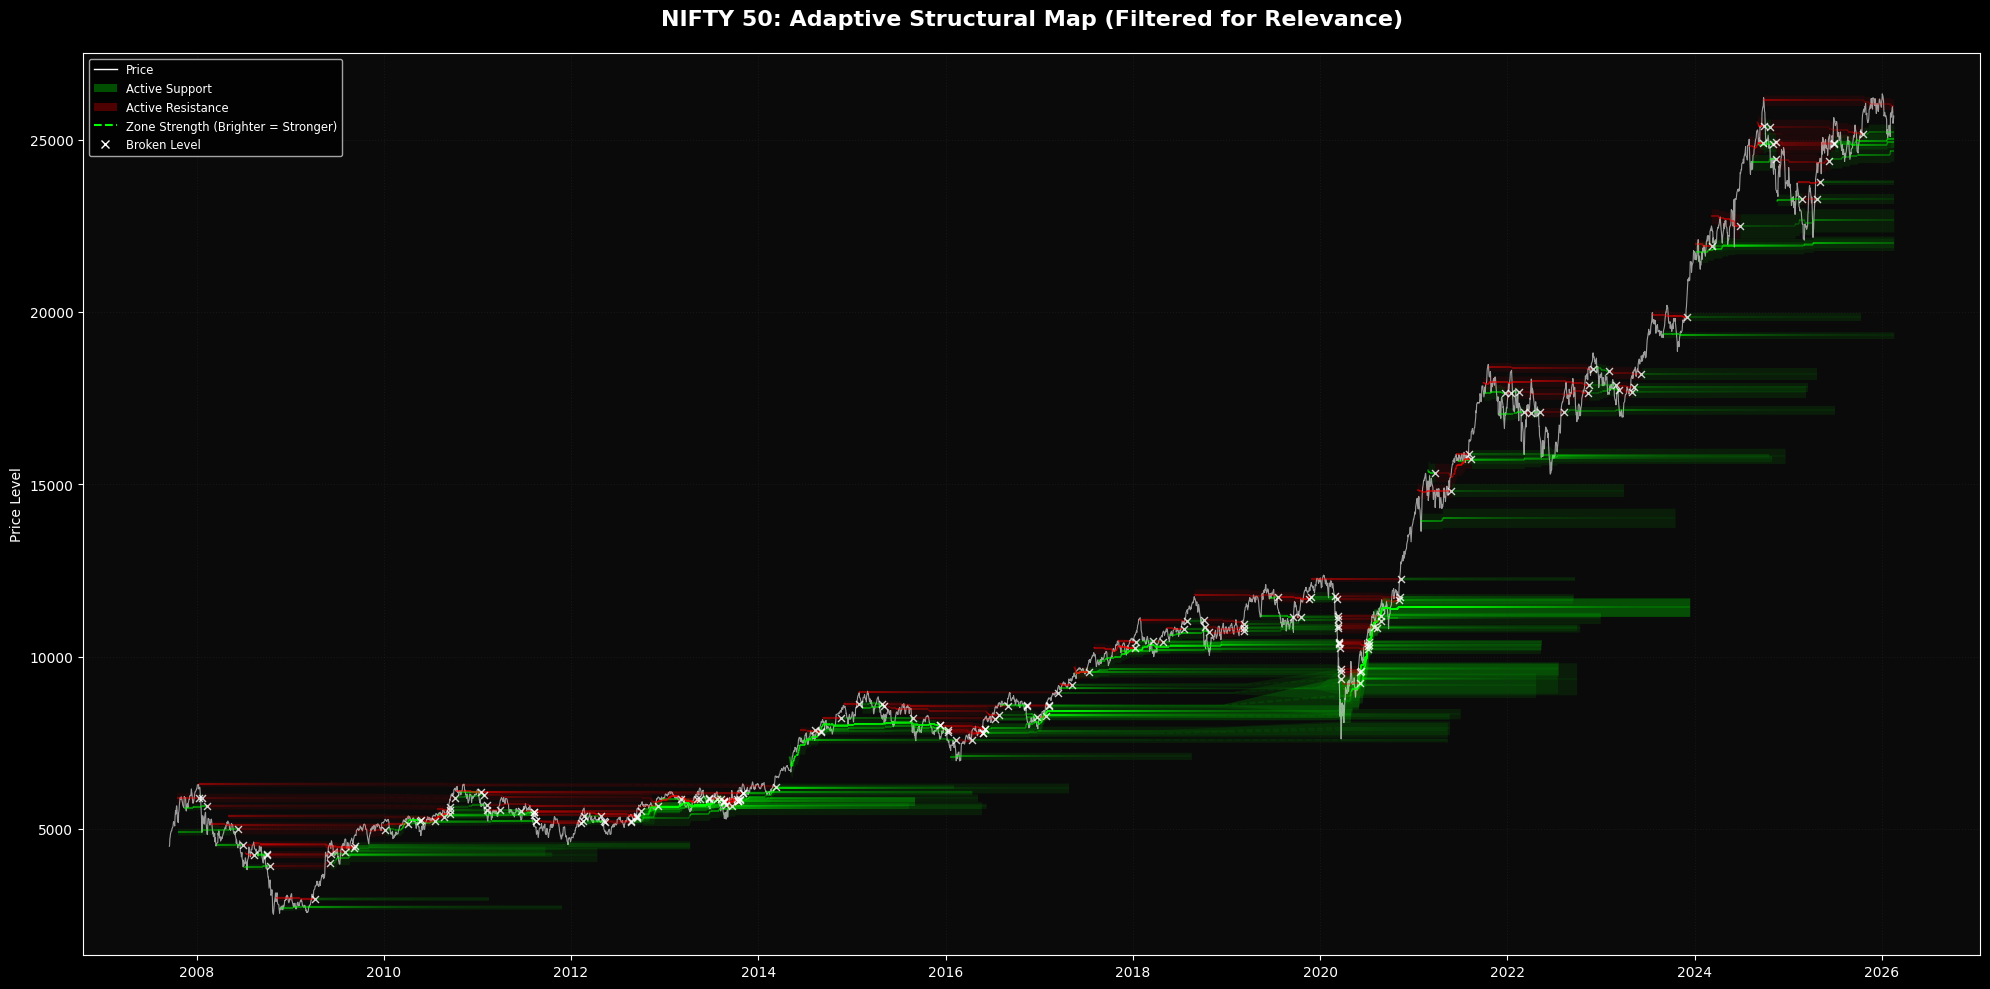

In [447]:
# --- PHASE 4: VISUALIZATION (Cleaned & Masked) ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('#0a0a0a')

# Plot Price (Thinner line to emphasize zones)
ax.plot(data['date'], data['close'], color='white', alpha=0.6, linewidth=0.8, label='Close Price')

def plot_zone_history_cleaned(ax, zones, color_hex, label):
    visible_count = 0
    # Convert hex to rgba for the fill
    base_rgba = to_rgba(color_hex)
    
    for zone in zones:
        if not zone['history']: continue
        
        # 1. Extract History
        hist_df = pd.DataFrame(zone['history'])
        
        mask = hist_df['strength'] > 0.05
        
        # If the whole zone is weak, skip it
        if not mask.any(): continue
        
        # Apply mask to data
        valid_df = hist_df[mask]
        
        dates = valid_df['date'].values
        means = valid_df['mean'].values
        uppers = valid_df['upper'].values
        lowers = valid_df['lower'].values
        strengths = valid_df['strength'].values
        
        # 2. Draw the "Tunnel" (Fill)
        # We use a very low alpha (0.05) to avoid the "Solid Block" effect when zones stack
        # We plot this using 'fill_between' on the masked data. 
        # Note: Gaps in dates will result in straight lines connecting segments, 
        # which is acceptable for visual continuity, or we can split loops (more complex).
        ax.fill_between(dates, lowers, uppers, color=color_hex, alpha=0.08, linewidth=0, zorder=1)
        
        # 3. Draw the "Mean Line" (Gradient Strength)
        # This is the most important visual element
        date_nums = mdates.date2num(dates)
        points = np.array([date_nums, means]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Map strength to Alpha (0.0 to 1.0)
        # We use the strength of the *start* of each segment
        seg_strengths = strengths[:-1]
        alphas = np.clip(seg_strengths * 0.5, 0.05, 0.9)
        
        lc = LineCollection(segments, colors=color_hex, linestyle='--', linewidth=1.2, zorder=2)
        lc.set_alpha(alphas)
        ax.add_collection(lc)
        
        # 4. Mark Death (Only if it happened)
        if pd.notnull(zone['death_date']):
             ax.scatter(zone['death_date'], zone['mean'], 
                        color='white', marker='x', s=25, alpha=0.8, zorder=3, linewidth=1)
             
        visible_count += 1

    print(f"Plotting {visible_count} {label} zones (Hidden {len(zones)-visible_count} ghosts).")

# Execute Plotter
plot_zone_history_cleaned(ax, living_support, '#00ff00', 'Support')
plot_zone_history_cleaned(ax, living_resistance, '#ff0000', 'Resistance')

# Formatting
ax.set_title("NIFTY 50: Adaptive Structural Map (Filtered for Relevance)", color='white', fontsize=16, fontweight='bold', pad=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, color='#333333', linestyle=':', alpha=0.3)
ax.set_ylabel("Price Level", color='white')

# Legend
legend_elements = [
    Line2D([0], [0], color='white', lw=1, label='Price'),
    Patch(facecolor='#00ff00', alpha=0.3, label='Active Support'),
    Patch(facecolor='#ff0000', alpha=0.3, label='Active Resistance'),
    Line2D([0], [0], color='#00ff00', linestyle='--', label='Zone Strength (Brighter = Stronger)'),
    Line2D([0], [0], marker='x', color='white', linestyle='None', label='Broken Level')
]
ax.legend(handles=legend_elements, loc='upper left', facecolor='black', fontsize='small')

plt.tight_layout()
plt.show()

In [448]:
# --- 1. INITIALIZE BINARY COLUMNS ---
# Create 'is_support' and 'is_resistance' columns initialized to 0
data['is_support'] = 0
data['is_resistance'] = 0

date_to_idx = {d: i for i, d in enumerate(data['date'])}

# --- 2. POPULATE THE BINARY MAP ---
def populate_binary_map(zones, column_name, opp_col_name):

    for zone in zones:
        b_idx = date_to_idx.get(zone['birth_date'])

        # Initializing a "True" price-zone interaction value at the time of zone birth
        if b_idx is not None:
            data.at[b_idx, column_name] = 1
            
        # # LOGIC B: "Lies in a Zone" (History Containment)
        # # Scan every day recorded in the zone's active history
        for record in zone['history']:
            # Extracting IDs of all the rows in nifty data corresponding to the zone lifetime
            idx = date_to_idx.get(record['date'])

            if idx is None: continue

            if data.iloc[idx][opp_col_name] == 1: data.at[idx, column_name] = 0
            
            # Access price action and structural bounds for that date
            row = data.iloc[idx]
            h, l = row['high'], row['low']
            # finding the midpoint of the candle in question at the moment
            mid = (h + l) / 2
            z_top, z_btm = record['upper'], record['lower']
            # Finding the width of the zone
            z_h = z_top - z_btm
            
            # STRICT CONTAINMENT LOGIC:
            # 1. Candle height <= Zone height: Must be fully contained.
            # 2. Candle height > Zone height: Midpoint must be inside.
            if (h - l) <= z_h:
                if h <= z_top and l >= z_btm:
                    data.at[idx, column_name] = 1
            else:
                if mid <= z_top and mid >= z_btm:
                    data.at[idx, column_name] = 1



# # --- 3. EXECUTE MAPPING ---
populate_binary_map(living_support, 'is_support', 'is_resistance')
populate_binary_map(living_resistance, 'is_resistance', 'is_support')

# --- 4. VERIFICATION ---
# Print the results of the mapping process
print("Structural Binary Map Created Successfully.")
print(f"Total Support Datapoints: {data['is_support'].sum()}")
print(f"Total Resistance Datapoints: {data['is_resistance'].sum()}")

# Inspect a small sample of positive interactions
print(data[data['is_support'] == 1][['date', 'close', 'is_support']].head())

Structural Binary Map Created Successfully.
Total Support Datapoints: 1212
Total Resistance Datapoints: 1129
         date        close  is_support
23 2007-10-19  5215.299805           1
38 2007-11-12  5617.100098           1
39 2007-11-13  5695.399902           1
45 2007-11-21  5561.049805           1
48 2007-11-26  5731.700195           1


In [449]:
data[(data['is_support'] == data['is_resistance']) & (data['is_support'] == 1) & (data['is_resistance'] == 1)]

,date,open,high,low,close,trend,detrended_price,smtrend,swing_high,swing_low,true_range,atr,is_support,is_resistance
101,2008-02-11,5120.549805,5126.399902,4803.600098,4857.000000,NaN,NaN,5085.074485,0,0,322.799805,248.671456,1,1
433,2009-06-30,4391.500000,4426.750000,4267.350098,4291.100098,3382.211990,26.872594,4318.636077,0,0,159.399902,128.000035,1,1
437,2009-07-06,4429.600098,4479.799805,4133.700195,4165.700195,3382.592490,23.151110,4216.295993,0,0,346.099609,142.657122,1,1
445,2009-07-16,4223.500000,4305.000000,4205.500000,4231.399902,3370.702490,25.534660,4257.514152,0,0,99.500000,132.910610,1,1
446,2009-07-17,4231.450195,4390.399902,4230.149902,4374.950195,3371.434990,29.765225,4319.220692,0,0,160.250000,137.996303,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,2024-10-23,24378.150391,24604.250000,24378.099609,24435.500000,23346.332197,4.665263,24503.660654,0,0,226.150391,283.446568,1,1
4197,2024-10-31,24349.849609,24372.449219,24172.599609,24205.349609,23426.956943,3.322637,24279.030770,0,0,199.849609,268.746373,1,1
4277,2025-02-24,22609.349609,22668.050781,22518.800781,22553.349609,24067.521504,-6.291350,22597.554211,0,0,277.099609,248.032227,1,1
4320,2025-05-05,24419.500000,24526.400391,24400.650391,24461.150391,24051.385508,1.703706,24371.907351,0,0,179.701172,316.074916,1,1


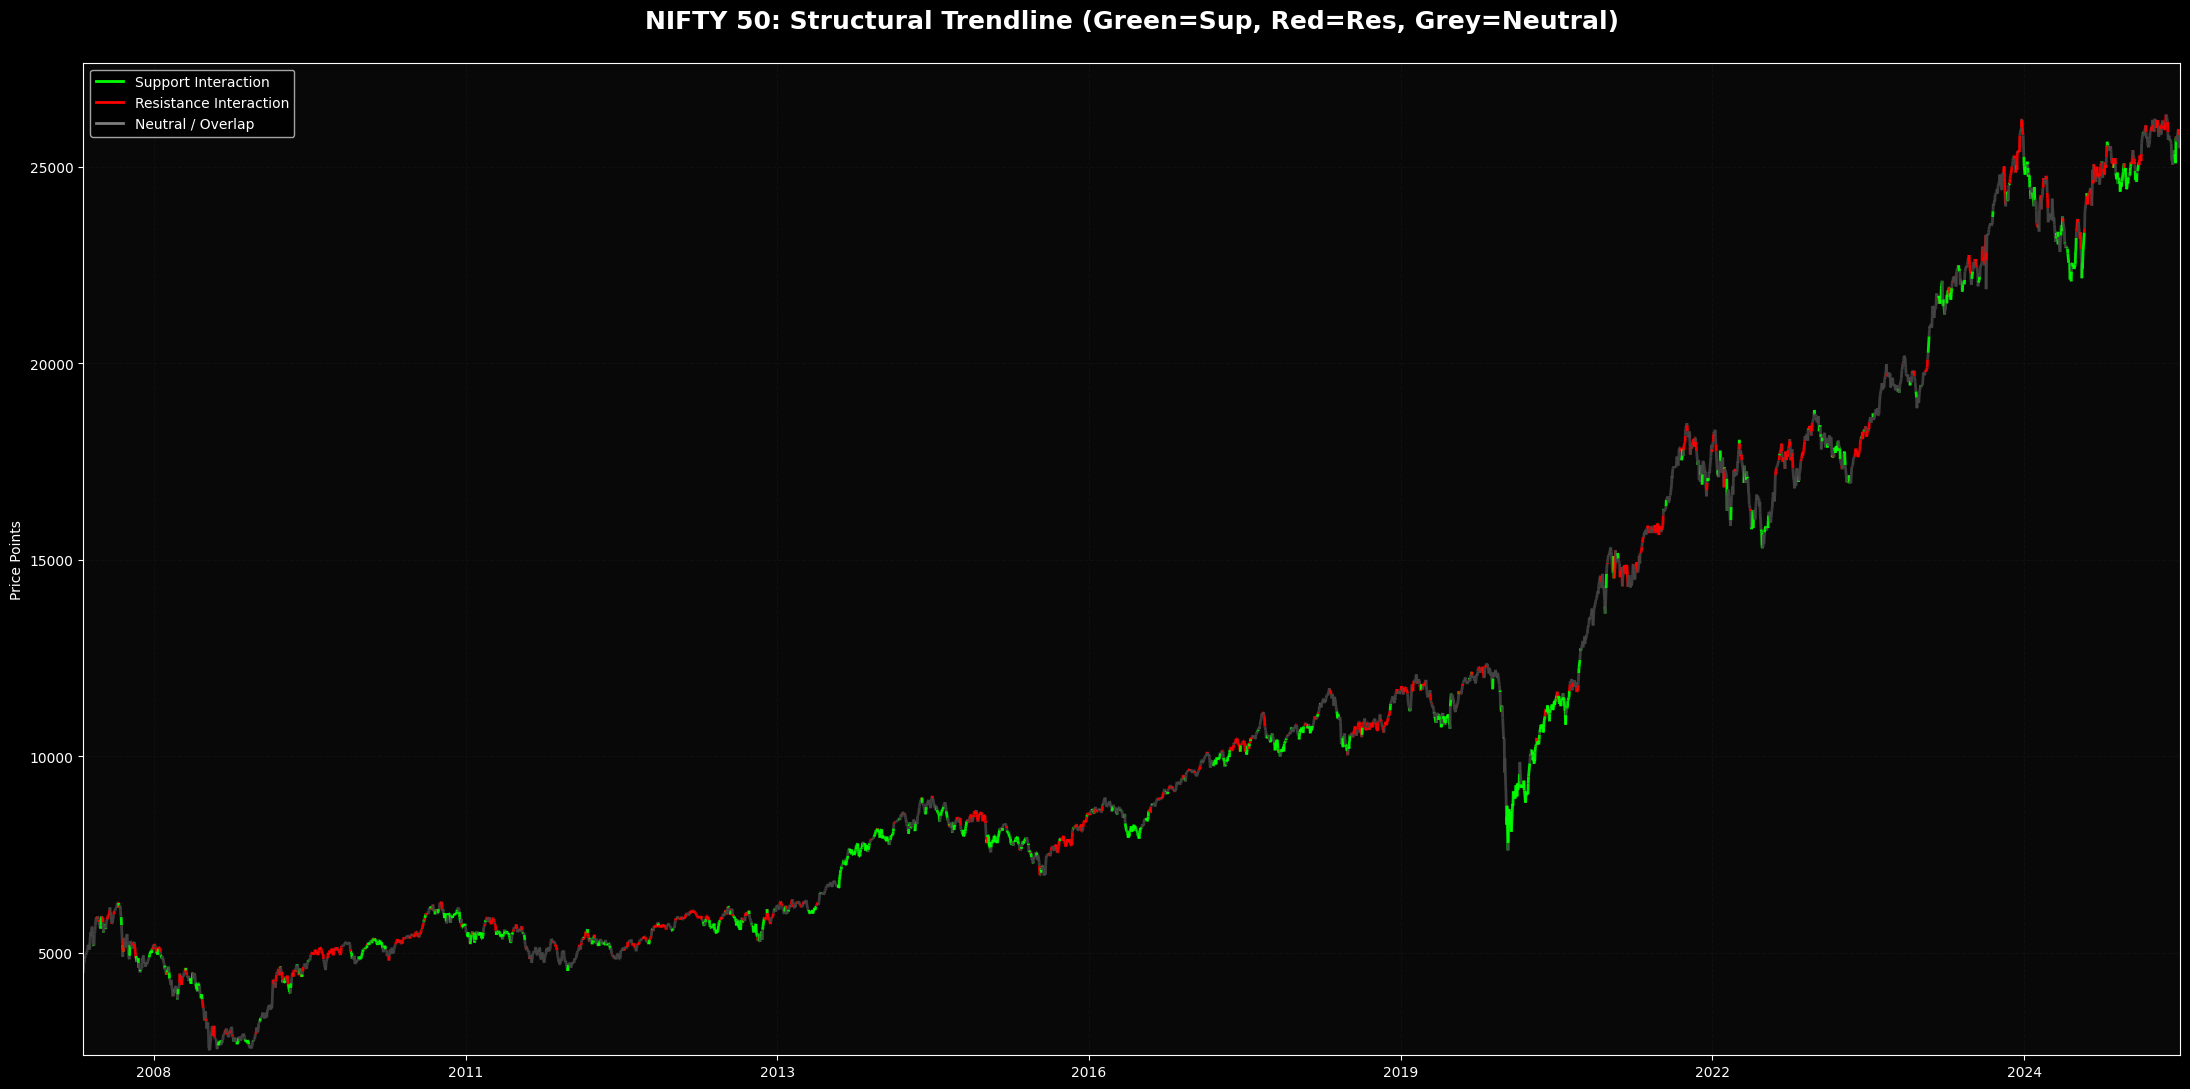

In [450]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

# 1. Map Colors to Segments based on your Binary Columns
# Logic: Support only = Green, Resistance only = Red, Both OR Neither = Grey
point_colors = []
for i in range(len(data)):
    s = data.at[i, 'is_support']
    r = data.at[i, 'is_resistance']
    
    if s == 1 and r == 1:
        point_colors.append('#444444') # Conflict -> Neutral
    elif s == 1:
        point_colors.append('#00ff00') # Support -> Green
    elif r == 1:
        point_colors.append('#ff0000') # Resistance -> Red
    else:
        point_colors.append('#444444') # Neutral -> Grey

# 2. Setup the Visualization
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(22, 11), facecolor='black')
ax.set_facecolor('#080808')

# 3. Prepare Coordinates
x = mdates.date2num(data['date'])
y = data['close'].values
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# We use the color of point 'i' to color the segment starting from it
seg_colors = point_colors[:-1]

# 4. Create and Add the Collection
lc = LineCollection(segments, colors=seg_colors, linewidth=2, alpha=0.9, zorder=2)
ax.add_collection(lc)

# --- THE FIX: MANUAL CAMERA ALIGNMENT ---
# Without these, the chart will be empty because it defaults to year 1970
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min() * 0.95, y.max() * 1.05)
# ----------------------------------------

# 5. Final Formatting
ax.set_title("NIFTY 50: Structural Trendline (Green=Sup, Red=Res, Grey=Neutral)", 
             color='white', fontsize=18, fontweight='bold', pad=25)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, color='#222222', linestyle='--', alpha=0.3)
ax.set_ylabel("Price Points", color='white')

# Legend
legend_elements = [
    Line2D([0], [0], color='#00ff00', lw=2, label='Support Interaction'),
    Line2D([0], [0], color='#ff0000', lw=2, label='Resistance Interaction'),
    Line2D([0], [0], color="#7D7D7D", lw=2, label='Neutral / Overlap')
]
ax.legend(handles=legend_elements, loc='upper left', facecolor='black', framealpha=0.8)

plt.tight_layout()
plt.show()

In [451]:
new_data = data.drop(columns=['trend', 'smtrend', 'swing_high', 'swing_low', 'true_range'])
new_data.reset_index(drop=True)

,date,open,high,low,close,detrended_price,atr,is_support,is_resistance
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,NaN,NaN,0,0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,NaN,NaN,0,0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,NaN,NaN,0,0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,NaN,NaN,0,0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...
4513,2026-02-10,25922.650391,25989.449219,25870.449219,25935.150391,2.642844,350.310268,0,1
4514,2026-02-11,25997.449219,26009.400391,25899.800781,25953.849609,2.682162,330.913923,0,1
4515,2026-02-12,25906.699219,25906.699219,25752.400391,25807.199219,2.066270,325.428153,0,0
4516,2026-02-13,25571.150391,25630.349609,25444.300781,25471.099609,0.714256,328.303153,0,0


In [452]:
is_res = []
is_sup = []

for row in new_data.itertuples(index=False):
    if row.is_support == 1 and row.is_resistance == 1:
        if is_res[-1] == 0:
            is_sup.append(0)
            is_res.append(1)
        elif is_sup[-1] == 0:
            is_sup.append(1)
            is_res.append(0)
    else:
        is_res.append(row.is_resistance)
        is_sup.append(row.is_support)
        

new_data['is_support'] = is_sup
new_data['is_resistance'] = is_res

    

In [453]:
# Initialize columns with a neutral large value (meaning no zone is nearby)
# or NaN if you prefer to drop rows with no active zones.
new_data['dist_support'] = np.nan
new_data['dist_resistance'] = np.nan

# 1. Iterate through the new_dataset row by row to prevent lookahead bias
for i, row in new_data.iterrows():
    curr_date = row['date']
    curr_close = row['close']
    curr_atr = row['atr']
    
    # Skip if ATR is not available (early new_data)
    if pd.isna(curr_atr) or curr_atr == 0:
        continue

    # --- CALCULATE DISTANCE TO NEAREST SUPPORT ---
    active_supports = []
    for z in living_support:
        # Time Constraint: Zone must be born, and either not dead or died AFTER today
        if z['birth_date'] <= curr_date:
            if pd.isnull(z['death_date']) or z['death_date'] >= curr_date:
                # Find the mean of this zone on this specific date from its history
                # This accounts for the 'drift' we implemented in the engine
                for record in z['history']:
                    if record['date'] == curr_date:
                        active_supports.append(record['mean'])
                        break
    
    if active_supports:
        # Find the nearest center
        nearest_sup = min(active_supports, key=lambda x: abs(curr_close - x))
        # Formula: (Close - Center) / ATR
        new_data.at[i, 'dist_support'] = (curr_close - nearest_sup) / curr_atr

    # --- CALCULATE DISTANCE TO NEAREST RESISTANCE ---
    active_resistances = []
    for z in living_resistance:
        if z['birth_date'] <= curr_date:
            if pd.isnull(z['death_date']) or z['death_date'] >= curr_date:
                for record in z['history']:
                    if record['date'] == curr_date:
                        active_resistances.append(record['mean'])
                        break
                        
    if active_resistances:
        # Find the nearest center
        nearest_res = min(active_resistances, key=lambda x: abs(curr_close - x))
        # Formula: (Center - Close) / ATR
        new_data.at[i, 'dist_resistance'] = (nearest_res - curr_close) / curr_atr

print("Memory features 'dist_support' and 'dist_resistance' added successfully.")

Memory features 'dist_support' and 'dist_resistance' added successfully.


In [454]:
# --- CLEANED & FUTURE-PROOF MEMORY FEATURES ---

# 1. Reset the index so row labels are 0, 1, 2... matching the loop 'i'
# This fixes the KeyError: 0 and makes bar-counting logic easier
new_data = new_data.reset_index(drop=True)

# 2. Initialize the columns
new_data['days_since_sup_int'] = 1000
new_data['days_since_res_int'] = 1000

last_sup_idx = -1
last_res_idx = -1

for i in range(len(new_data)):
    # 1. Update Support Interaction Timer
    # Use .at[i, 'col'] directly on the dataframe to avoid ChainedAssignmentError
    if new_data.at[i, 'is_support'] == 1:
        last_sup_idx = i
    
    if last_sup_idx != -1:
        new_data.at[i, 'days_since_sup_int'] = i - last_sup_idx

    # 2. Update Resistance Interaction Timer
    if new_data.at[i, 'is_resistance'] == 1:
        last_res_idx = i
        
    if last_res_idx != -1:
        new_data.at[i, 'days_since_res_int'] = i - last_res_idx

print("Features calculated without warnings.")

Features calculated without warnings.


In [455]:
# --- CALCULATING ZONE DENSITY (STRUCTURAL CONFLUENCE) ---

# Initialize the feature column
new_data['zone_density'] = 0

for i in range(len(new_data)):
    curr_date = new_data.at[i, 'date']
    curr_close = new_data.at[i, 'close']
    curr_atr = new_data.at[i, 'atr']
    
    if pd.isna(curr_atr) or curr_atr == 0:
        continue

    # Define the "Confluence Box"
    threshold = 1.5 * curr_atr
    upper_bound = curr_close + threshold
    lower_bound = curr_close - threshold
    
    active_count = 0
    
    # Check Support Zones
    for z in living_support:
        # Time Constraint
        if z['birth_date'] <= curr_date:
            if pd.isnull(z['death_date']) or z['death_date'] >= curr_date:
                # Find the mean at this specific moment in time
                for record in z['history']:
                    if record['date'] == curr_date:
                        if lower_bound <= record['mean'] <= upper_bound:
                            active_count += 1
                        break
    
    # Check Resistance Zones
    for z in living_resistance:
        if z['birth_date'] <= curr_date:
            if pd.isnull(z['death_date']) or z['death_date'] >= curr_date:
                for record in z['history']:
                    if record['date'] == curr_date:
                        if lower_bound <= record['mean'] <= upper_bound:
                            active_count += 1
                        break
                        
    # Assign the final count to the dataframe
    new_data.at[i, 'zone_density'] = active_count

print(f"Zone Density calculated. Max confluence found: {new_data['zone_density'].max()} zones.")
print('Value Counts for number of zones')
print(new_data['zone_density'].value_counts())

Zone Density calculated. Max confluence found: 14 zones.
Value Counts for number of zones
zone_density
1     1597
2     1092
0      940
3      450
4      240
5       62
6       54
7       31
9       17
8       16
10       6
11       4
12       4
14       3
13       2
Name: count, dtype: int64


In [456]:
# --- CALCULATING RANGE COMPRESSION MEMORY ---

# Define the Lookback Period (N days)
N_compression = 14

# 1. Calculate Rolling Extremes
# highest high over last N days
rolling_high = new_data['high'].rolling(window=N_compression).max()

# lowest low over last N days
rolling_low = new_data['low'].rolling(window=N_compression).min()

# 2. Calculate Rolling Range
rolling_range = rolling_high - rolling_low

# 3. Calculate Compression Ratio
# Normalized by ATR to make it comparable across different price regimes
new_data['compression_ratio'] = rolling_range / new_data['atr']

# 4. Handle early NaNs (first N-1 rows)
new_data['compression_ratio'] = new_data['compression_ratio'].fillna(0)

print("Range Compression Ratio added successfully.")


Range Compression Ratio added successfully.


In [457]:
# 1. Calculate the absolute physical size of the gap
# Gap Up = Today's Low minus Yesterday's High
gap_up_size = new_data['low'] - new_data['high'].shift(1)

# Gap Down = Yesterday's Low minus Today's High
gap_down_size = new_data['low'].shift(1) - new_data['high']

# 2. Define the Dynamic Threshold
# We use yesterday's ATR so the threshold isn't artificially inflated by today's massive gap
threshold = 0.5 * new_data['atr'].shift(1)

# 3. Identify ONLY Significant Gaps
# Must be an actual gap (> 0) AND larger than the threshold
new_data['is_sig_gap_up'] = (gap_up_size > 0) & (gap_up_size > threshold)
new_data['is_sig_gap_down'] = (gap_down_size > 0) & (gap_down_size > threshold)

new_data['is_sig_gap_up'] = new_data['is_sig_gap_up'].astype(int)
new_data['is_sig_gap_down'] = new_data['is_sig_gap_down'].astype(int)

# Optional: Print the results to verify
print(f"Total Gap Ups: {(gap_up_size > 0).sum()} | Significant Gap Ups: {new_data['is_sig_gap_up'].sum()}")
print(f"Total Gap Downs: {(gap_down_size > 0).sum()} | Significant Gap Downs: {new_data['is_sig_gap_down'].sum()}")

Total Gap Ups: 335 | Significant Gap Ups: 36
Total Gap Downs: 175 | Significant Gap Downs: 32


In [458]:
# --- CALCULATING PRIOR HIGH/LOW DISTANCE MEMORY ---

# Define the institutional lookback windows (N in days)
# 20 (1 Month), 50 (1 Quarter), 100 (Half Year), 252 (1 Year)
lookback_windows = [50, 100]

for N in lookback_windows:
    # 1. Calculate the Rolling Extremes over the last N days
    rolling_high = new_data['high'].rolling(window=N).max()
    rolling_low = new_data['low'].rolling(window=N).min()
    
    # 2. Calculate Normalized Distance to Rolling High
    # Formula: (Close_t - RollingHigh_N) / ATR_t
    # Values will be negative (below high) or 0 (at the high)
    high_col_name = f'dist_to_{N}d_high'
    new_data[high_col_name] = (new_data['close'] - rolling_high) / new_data['atr']
    
    # 3. Calculate Normalized Distance to Rolling Low
    # Formula: (Close_t - RollingLow_N) / ATR_t
    # Values will be positive (above low) or 0 (at the low)
    low_col_name = f'dist_to_{N}d_low'
    new_data[low_col_name] = (new_data['close'] - rolling_low) / new_data['atr']

print("Prior High/Low Distance features calculated successfully.")

Prior High/Low Distance features calculated successfully.


In [459]:

# --- 1. CALCULATE RAW WICKS ---
# Upper Wick = High - Max(Open, Close)
upper_wick = new_data['high'] - new_data[['open', 'close']].max(axis=1)

# Lower Wick = Min(Open, Close) - Low
lower_wick = new_data[['open', 'close']].min(axis=1) - new_data['low']

# --- 2. NORMALIZE WICKS ---
# Normalize by ATR to find structurally significant rejections
new_data['upper_wick_norm'] = upper_wick / new_data['atr']
new_data['lower_wick_norm'] = lower_wick / new_data['atr']

# --- 3. INITIALIZE WICK MEMORY TRACKING ---
# We will keep a rolling memory of the last N significant wicks
N_wicks = 10
threshold_atr = 1.0  # A wick > 1.0 ATR is a major rejection

mem_upper_wicks = []  # Stores dicts: {'level': High, 'idx': Index, 'norm': Size}
mem_lower_wicks = []  # Stores dicts: {'level': Low, 'idx': Index, 'norm': Size}

# Initialize new feature columns
new_data['dist_to_nearest_up_wick'] = np.nan
new_data['age_of_nearest_up_wick'] = np.nan
new_data['upper_wick_pressure'] = 0.0

new_data['dist_to_nearest_dn_wick'] = np.nan
new_data['age_of_nearest_dn_wick'] = np.nan
new_data['lower_wick_pressure'] = 0.0

# --- 4. POPULATE WICK MEMORY FEATURES ---
for i in range(len(new_data)):
    curr_close = new_data.at[i, 'close']
    curr_atr = new_data.at[i, 'atr']
    
    if pd.isna(curr_atr) or curr_atr == 0:
        continue
        
    # A. Process Upper Wicks (Seller Memory / Resistance)
    if mem_upper_wicks:
        # Find nearest upper wick level
        nearest_up = min(mem_upper_wicks, key=lambda x: abs(curr_close - x['level']))
        
        # Volatility-Normalized Distance: (Close - Wick_High) / ATR
        new_data.at[i, 'dist_to_nearest_up_wick'] = (curr_close - nearest_up['level']) / curr_atr
        new_data.at[i, 'age_of_nearest_up_wick'] = i - nearest_up['idx']
        
        # Time-Decaying Pressure Score: Sum of (Wick_Size / Age)
        up_pressure = sum([w['norm'] / max(1, i - w['idx']) for w in mem_upper_wicks])
        new_data.at[i, 'upper_wick_pressure'] = up_pressure

    # B. Process Lower Wicks (Buyer Memory / Support)
    if mem_lower_wicks:
        # Find nearest lower wick level
        nearest_dn = min(mem_lower_wicks, key=lambda x: abs(curr_close - x['level']))
        
        # Volatility-Normalized Distance: (Close - Wick_Low) / ATR
        new_data.at[i, 'dist_to_nearest_dn_wick'] = (curr_close - nearest_dn['level']) / curr_atr
        new_data.at[i, 'age_of_nearest_dn_wick'] = i - nearest_dn['idx']
        
        # Time-Decaying Pressure Score: Sum of (Wick_Size / Age)
        dn_pressure = sum([w['norm'] / max(1, i - w['idx']) for w in mem_lower_wicks])
        new_data.at[i, 'lower_wick_pressure'] = dn_pressure

    # C. UPDATE MEMORY (Done AFTER feature calculation to prevent lookahead bias)
    if new_data.at[i, 'upper_wick_norm'] > threshold_atr:
        mem_upper_wicks.append({
            'level': new_data.at[i, 'high'], 
            'idx': i, 
            'norm': new_data.at[i, 'upper_wick_norm']
        })
        if len(mem_upper_wicks) > N_wicks:
            mem_upper_wicks.pop(0)  # Keep only the last N wicks
            
    if new_data.at[i, 'lower_wick_norm'] > threshold_atr:
        mem_lower_wicks.append({
            'level': new_data.at[i, 'low'], 
            'idx': i, 
            'norm': new_data.at[i, 'lower_wick_norm']
        })
        if len(mem_lower_wicks) > N_wicks:
            mem_lower_wicks.pop(0)

# Fill early NaNs with neutral values
new_data['dist_to_nearest_up_wick'] = new_data['dist_to_nearest_up_wick'].fillna(10.0)
new_data['dist_to_nearest_dn_wick'] = new_data['dist_to_nearest_dn_wick'].fillna(-10.0)
new_data['age_of_nearest_up_wick'] = new_data['age_of_nearest_up_wick'].fillna(1000)
new_data['age_of_nearest_dn_wick'] = new_data['age_of_nearest_dn_wick'].fillna(1000)

print("Wick Memory Features calculated successfully.")

Wick Memory Features calculated successfully.


In [460]:
# --- 1. CALCULATE THE MACRO ANCHOR ---
# 200-period Simple Moving Average
new_data['sma_200'] = new_data['close'].rolling(window=200).mean()

# --- 2. CALCULATE BINARY REGIME FLAGS ---
# 1 if Close is strictly greater than 200 SMA, else 0
new_data['is_above_200SMA'] = (new_data['close'] > new_data['sma_200']).astype(int)

# 1 if Close is strictly less than 200 SMA, else 0
new_data['is_below_200SMA'] = (new_data['close'] < new_data['sma_200']).astype(int)

# Note: We use strictly greater/less than. If price is exactly ON the SMA, 
# both flags will be 0, which correctly represents a "Neutral / Decision" state.

# --- 3. CALCULATE MACRO TREND SLOPE ---
# We measure the change in the 200 SMA over the last 20 days (approx. 1 month)
lookback_k = 20
sma_diff = new_data['sma_200'].diff(periods=lookback_k)

# np.sign() returns:
#  1 for positive (Rising SMA / Bull Trend)
# -1 for negative (Falling SMA / Bear Trend)
#  0 for flat
new_data['trend_slope_sign'] = np.sign(sma_diff)

# --- 4. HANDLE EARLY NANS ---
# The first 200 days won't have an SMA. We can fill these with a neutral baseline 
# or leave them as NaN if you plan to drop early rows before training.
new_data['is_above_200SMA'] = new_data['is_above_200SMA'].fillna(0)
new_data['is_below_200SMA'] = new_data['is_below_200SMA'].fillna(0)
new_data['trend_slope_sign'] = new_data['trend_slope_sign'].fillna(0)

print("Structured Regime flags calculated successfully.")

Structured Regime flags calculated successfully.


In [461]:
# # correlation = 
# new_data[
#     ['detrended_price', 'atr', 'dist_support', 
#      'dist_resistance', 'days_since_sup_int', 
#      'days_since_res_int', 'zone_density', 
#      'compression_ratio', 'is_sig_gap_up', 
#      'is_sig_gap_down', 'dist_to_50d_high', 
#      'dist_to_50d_low', 'dist_to_100d_high', 
#      'dist_to_100d_low', 'upper_wick_norm', 
#      'lower_wick_norm', 'dist_to_nearest_up_wick', 
#      'age_of_nearest_up_wick', 'upper_wick_pressure', 
#      'dist_to_nearest_dn_wick', 'age_of_nearest_dn_wick', 
#      'lower_wick_pressure','sma_200', 'is_above_200SMA', 
#      'is_below_200SMA', 'trend_slope_sign', 
#      'is_support', 'is_resistance']
# ].dropna().cov()    #[['is_support', 'is_resistance']]

# # correlation[(correlation['is_support'] > 0.05) | (correlation['is_resistance'] > 0.05)]

In [462]:
tested = new_data.dropna()

In [463]:
y1 = tested['is_support']
y2 = tested['is_resistance']

X = tested.drop(columns=['date', 'is_support', 'is_resistance', 'open', 'high', 'close', 'low'])

In [464]:
X.head()

,detrended_price,atr,dist_support,dist_resistance,days_since_sup_int,days_since_res_int,zone_density,compression_ratio,is_sig_gap_up,is_sig_gap_down,...,dist_to_nearest_up_wick,age_of_nearest_up_wick,upper_wick_pressure,dist_to_nearest_dn_wick,age_of_nearest_dn_wick,lower_wick_pressure,sma_200,is_above_200SMA,is_below_200SMA,trend_slope_sign
199,-22.659392,158.049962,0.791838,3.238672,1,5,1,5.260995,0,0,...,10.0,1000.0,0.0,-2.647897,112.0,0.042068,5210.716744,0,1,0.0
200,-23.417676,159.771380,0.523874,3.463211,2,6,1,4.615659,0,0,...,10.0,1000.0,0.0,-2.878801,113.0,0.041742,5208.186245,0,1,0.0
201,-20.151597,165.778512,1.521609,0.805693,3,0,1,4.124479,0,0,...,10.0,1000.0,0.0,-1.757766,114.0,0.041421,5206.240745,0,1,0.0
202,-20.009836,157.146397,1.637646,0.817495,4,1,1,3.200200,0,0,...,10.0,1000.0,0.0,-1.821867,115.0,0.041105,5203.389995,0,1,0.0
203,-22.133077,162.532122,0.886902,1.328804,5,2,2,2.931728,0,0,...,10.0,1000.0,0.0,-2.457976,116.0,0.040795,5199.897246,0,1,0.0


In [465]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

support

In [466]:
from sklearn.linear_model import LogisticRegression

# For Support
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_scaled, y1)

coef_df1 = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model1.coef_[0]
})
coef_df1 = coef_df1.sort_values('coefficient', key=abs, ascending=False)
support_train_columns = coef_df1[(coef_df1['coefficient'] > 0.1) | (coef_df1['coefficient'] < -0.1)]['feature'].values

# For Resistance
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_scaled, y2)

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model2.coef_[0]
})
coef_df = coef_df.sort_values('coefficient', key=abs, ascending=False)
resistance_train_columns = coef_df[(coef_df['coefficient'] > 0.1) | (coef_df['coefficient'] < -0.1)]['feature'].values


In [467]:
def train_and_evaluate_svms(df, sup_feature_columns, res_feature_columns, test_size=0.2):

    print("--- Preparing Stratified Data for SVM ---")
    
    # 1. Clean Data
    feature_columns = np.union1d(sup_feature_columns, res_feature_columns)
    required_cols = list(feature_columns) + ['is_support', 'is_resistance']
    clean_data = df[required_cols].dropna().reset_index(drop=True)  
    print(f"Total usable rows after dropping NaNs: {len(clean_data)}\n")
    

    X_sup = clean_data[sup_feature_columns]
    X_res = clean_data[res_feature_columns]

    y_sup = clean_data['is_support']
    y_res = clean_data['is_resistance']
    
    # ==========================================
    # 2. SUPPORT PIPELINE (Stratified Split)
    # ==========================================
    # stratify=y_sup ensures the exact same ratio of 1s and 0s in Train and Test
    X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(
        X_sup, y_sup, test_size=test_size, stratify=y_sup, random_state=42
    )
    
    scaler_sup = StandardScaler()
    X_train_sup_scaled = scaler_sup.fit_transform(X_train_sup)
    X_test_sup_scaled = scaler_sup.transform(X_test_sup)
    
    svm_support = SVC(kernel='rbf', C=5.0, gamma=0.5, class_weight={0: 1.0, 1: 1.5}, random_state=68)
    print("Training Support SVM...")
    svm_support.fit(X_train_sup_scaled, y_train_sup)
    y_sup_pred = svm_support.predict(X_test_sup_scaled)
    
    # ==========================================
    # 3. RESISTANCE PIPELINE (Stratified Split)
    # ==========================================
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
        X_res, y_res, test_size=test_size, stratify=y_res, random_state=42
    )
    
    scaler_res = StandardScaler()
    X_train_res_scaled = scaler_res.fit_transform(X_train_res)
    X_test_res_scaled = scaler_res.transform(X_test_res)
    
    svm_resistance = SVC(kernel='rbf', C=5.0, gamma=0.5, class_weight={0: 1.0, 1: 1.5}, random_state=68)
    print("Training Resistance SVM...")
    svm_resistance.fit(X_train_res_scaled, y_train_res)
    y_res_pred = svm_resistance.predict(X_test_res_scaled)
    
    # ==========================================
    # 4. METRICS COLLECTION
    # ==========================================
    metrics = {
        'Support': {
            'Accuracy': accuracy_score(y_test_sup, y_sup_pred),
            'Precision': precision_score(y_test_sup, y_sup_pred, zero_division=0),
            'Recall': recall_score(y_test_sup, y_sup_pred, zero_division=0),
            'F1_Score': f1_score(y_test_sup, y_sup_pred, zero_division=0),
            'Report': classification_report(y_test_sup, y_sup_pred, zero_division=0)
        },
        'Resistance': {
            'Accuracy': accuracy_score(y_test_res, y_res_pred),
            'Precision': precision_score(y_test_res, y_res_pred, zero_division=0),
            'Recall': recall_score(y_test_res, y_res_pred, zero_division=0),
            'F1_Score': f1_score(y_test_res, y_res_pred, zero_division=0),
            'Report': classification_report(y_test_res, y_res_pred, zero_division=0)
        }
    }
    
    # ==========================================
    # 5. PRINT RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("🎯 STRATIFIED SVM PERFORMANCE METRICS 🎯")
    print("="*40)
    
    for target in ['Support', 'Resistance']:
        print(f"\n--- {target} Model ---")
        print(f"Accuracy:  {metrics[target]['Accuracy']:.4f}")
        print(f"Precision: {metrics[target]['Precision']:.4f}")
        print(f"Recall:    {metrics[target]['Recall']:.4f}")
        print(f"F1 Score:  {metrics[target]['F1_Score']:.4f}")
        print("\nDetailed Classification Report:")
        print(metrics[target]['Report'])
        
    return {
        'models': {'support': svm_support, 'resistance': svm_resistance},
        'scalers': {'support': scaler_sup, 'resistance': scaler_res},
        'metrics': metrics
    }

In [468]:
test_size = 0.3

feature_columns = np.union1d(support_train_columns, resistance_train_columns)
required_cols = list(feature_columns) + ['is_support', 'is_resistance', 'date']
clean_data = new_data[required_cols].dropna().reset_index(drop=True)  
print(f"Total usable rows after dropping NaNs: {len(clean_data)}\n")

Total usable rows after dropping NaNs: 4419



In [469]:
# Ensure date is a datetime object, then extract the year
clean_data['date'] = pd.to_datetime(clean_data['date'])
clean_data['year'] = clean_data['date'].dt.year

# Create combined keys for stratification: "Year_Target"
y_sup_strat = clean_data['year'].astype(str) + "_" + clean_data['is_support'].astype(str)
y_res_strat = clean_data['year'].astype(str) + "_" + clean_data['is_resistance'].astype(str)

In [470]:
y_sup_strat.value_counts()

2021_0    229
2023_0    213
2022_0    210
2009_0    206
2019_0    205
2012_0    199
2024_0    195
2016_0    188
2025_0    182
2017_0    181
2018_0    175
2008_0    173
2013_0    171
2011_0    170
2010_0    166
2015_0    155
2020_0    125
2020_1    125
2014_0    123
2014_1    117
2015_1     89
2010_1     84
2013_1     76
2011_1     72
2018_1     70
2025_1     67
2017_1     67
2016_1     56
2024_1     51
2008_1     45
2012_1     43
2022_1     38
2019_1     36
2009_1     35
2023_1     32
2026_0     28
2021_1     19
2026_1      3
Name: count, dtype: int64

In [471]:
X_sup = clean_data[support_train_columns]
X_res = clean_data[resistance_train_columns]

y_sup = clean_data['is_support']
y_res = clean_data['is_resistance']

Support

In [472]:
X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(
    X_sup, y_sup, test_size=test_size, stratify=y_sup_strat, random_state=42
)

In [473]:
scaler_sup = StandardScaler()
X_train_sup_scaled = scaler_sup.fit_transform(X_train_sup)
X_test_sup_scaled = scaler_sup.transform(X_test_sup)

In [474]:
svm_support = SVC(kernel='rbf', C=5.0, gamma=0.5, class_weight={0: 1.0, 1: 1.5}, random_state=68)
print("Training Support SVM...")
svm_support.fit(X_train_sup_scaled, y_train_sup)
y_sup_pred = svm_support.predict(X_test_sup_scaled)

Training Support SVM...


In [475]:
y_train_sup.value_counts()

is_support
0    2305
1     788
Name: count, dtype: int64

In [476]:
y_test_sup.value_counts()

is_support
0    989
1    337
Name: count, dtype: int64

Resistance

In [477]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_res, y_res, test_size=test_size, stratify=y_res_strat, random_state=42
)

In [478]:
scaler_res = StandardScaler()
X_train_res_scaled = scaler_res.fit_transform(X_train_res)
X_test_res_scaled = scaler_res.transform(X_test_res)

In [479]:
svm_resistance = SVC(kernel='rbf', C=5.0, gamma=0.5, class_weight={0: 1.0, 1: 1.5}, random_state=68)
print("Training Resistance SVM...")
svm_resistance.fit(X_train_res_scaled, y_train_res)
y_res_pred = svm_resistance.predict(X_test_res_scaled)

Training Resistance SVM...


In [480]:
y_train_res.value_counts()

is_resistance
0    2357
1     736
Name: count, dtype: int64

In [481]:
y_test_res.value_counts()

is_resistance
0    1010
1     316
Name: count, dtype: int64

Metrics

In [482]:
metrics = {
    'Support': {
        'Accuracy': accuracy_score(y_test_sup, y_sup_pred),
        'Precision': precision_score(y_test_sup, y_sup_pred, zero_division=0),
        'Recall': recall_score(y_test_sup, y_sup_pred, zero_division=0),
        'F1_Score': f1_score(y_test_sup, y_sup_pred, zero_division=0),
        'Report': classification_report(y_test_sup, y_sup_pred, zero_division=0)
    },
    'Resistance': {
        'Accuracy': accuracy_score(y_test_res, y_res_pred),
        'Precision': precision_score(y_test_res, y_res_pred, zero_division=0),
        'Recall': recall_score(y_test_res, y_res_pred, zero_division=0),
        'F1_Score': f1_score(y_test_res, y_res_pred, zero_division=0),
        'Report': classification_report(y_test_res, y_res_pred, zero_division=0)
    }
}

In [483]:
print("\n" + "="*40)
print("STRATIFIED SVM PERFORMANCE METRICS")
print("="*40)

for target in ['Support', 'Resistance']:
    print(f"\n--- {target} Model ---")
    print(f"Accuracy:  {metrics[target]['Accuracy']:.4f}")
    print(f"Precision: {metrics[target]['Precision']:.4f}")
    print(f"Recall:    {metrics[target]['Recall']:.4f}")
    print(f"F1 Score:  {metrics[target]['F1_Score']:.4f}")
    print("\nDetailed Classification Report:")
    print(metrics[target]['Report'])


STRATIFIED SVM PERFORMANCE METRICS

--- Support Model ---
Accuracy:  0.9329
Precision: 0.8212
Recall:    0.9407
F1 Score:  0.8769

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       989
           1       0.82      0.94      0.88       337

    accuracy                           0.93      1326
   macro avg       0.90      0.94      0.92      1326
weighted avg       0.94      0.93      0.93      1326


--- Resistance Model ---
Accuracy:  0.9623
Precision: 0.8757
Recall:    0.9810
F1 Score:  0.9254

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1010
           1       0.88      0.98      0.93       316

    accuracy                           0.96      1326
   macro avg       0.93      0.97      0.95      1326
weighted avg       0.97      0.96      0.96      1326



In [484]:
# train_and_evaluate_svms(new_data, support_train_columns, resistance_train_columns)